In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
import pickle
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_cal/"
res_DIR = "../data/results_cal/"

In [2]:
parameter_values = get_parameter_values()

In [3]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [4]:
cell = 22
# cell = 23
sim_des = "cal"
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
calendar_time = 24
experiment = pybamm.Experiment(
    [
        ("Rest for "+f'{calendar_time}'+" hours",)
    ]*int(N[-1]+10) ,
    termination="50% capacity",
#     cccv_handling="ode",
)
parameter_values = get_parameter_values()

parameter_values.update(
    {
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
        "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
        # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
    },
    check_already_exists=False,
)

In [5]:
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'wb') as handle:
        pickle.dump(all_sumvars_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# fig = plotc(all_sumvars_dict,dfe);
# plt.savefig(fig_DIR +'calendar_aging_cell_'+cell_no+'_eSOH.png')

In [6]:
cell = 24
# cell = 23
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
calendar_time = 24
experiment = pybamm.Experiment(
    [
        ("Rest for "+f'{calendar_time}'+" hours",)
    ]*int(N[-1]+10) ,
    termination="50% capacity",
#     cccv_handling="ode",
)
parameter_values = get_parameter_values()

parameter_values.update(
    {
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
        "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
        # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
    },
    check_already_exists=False,
)

In [7]:
all_sumvars_dict1 = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'wb') as handle:
        pickle.dump(all_sumvars_dict1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
def plotc4(all_sumvars_dict1,all_sumvars_dict2,esoh_data,esoh_data_2,leg1="sim1",leg2="sim2"):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"r^")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"bv")
        ax.plot(esoh_data_2["N"],esoh_data_2[name],"kx")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend([leg1, "Data", leg2 ], 
           loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [9]:
cell = 22
# cell = 23
cell_no,dfe1,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)

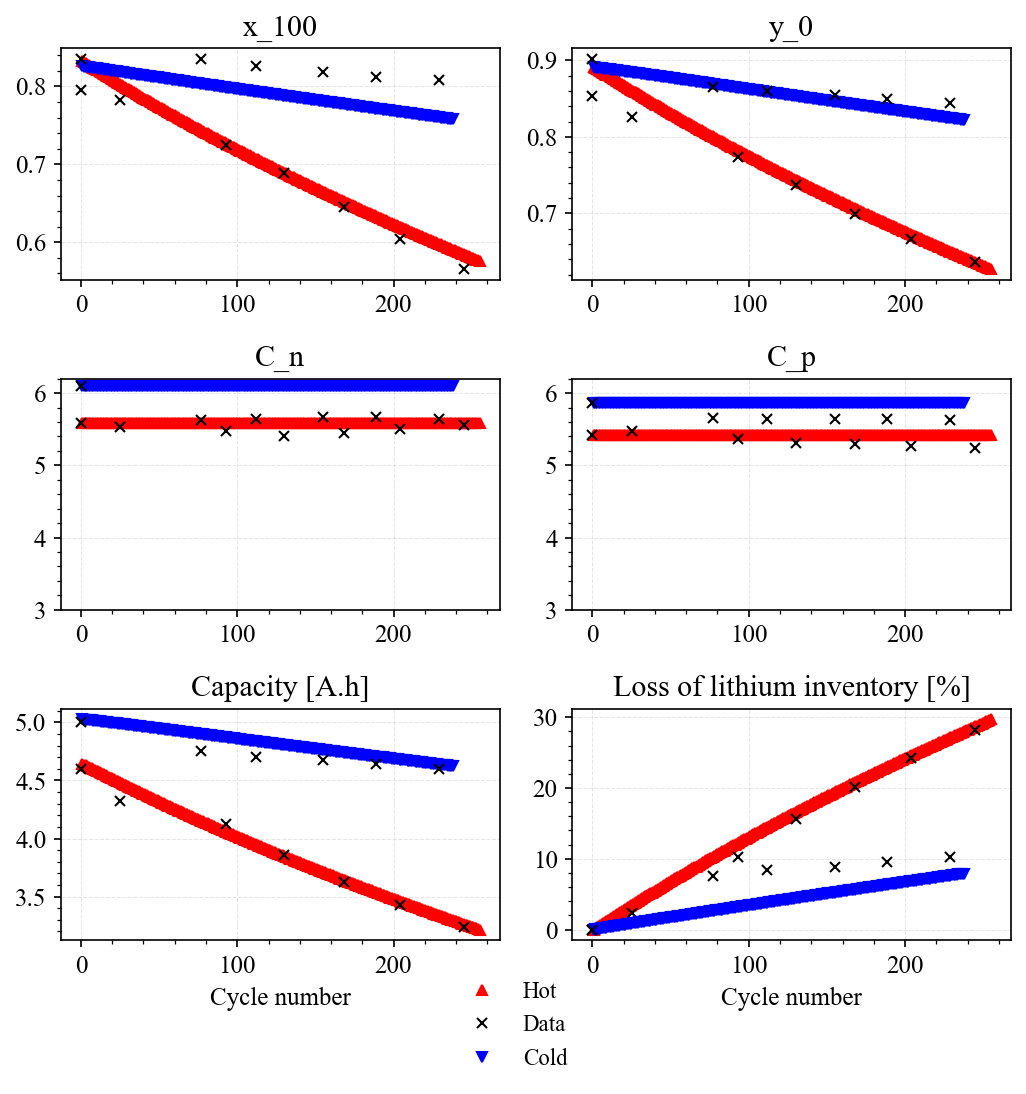

In [10]:
fig = plotc4(all_sumvars_dict,all_sumvars_dict1,dfe1,dfe,leg1="Hot",leg2="Cold");
fig.savefig(fig_DIR +'calendar_aging'+'_hot_cold.png')

In [11]:
#  vcxvxcv

NameError: name 'vcxvxcv' is not defined

In [ ]:
def plot_comp(all_sumvars_dict_0,all_sumvars_dict_1,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(all_sumvars_dict_0["Cycle number"],all_sumvars_dict_0[name],"ro")
        # ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.axvline(x = all_sumvars_dict_0["Cycle number"][-1], color = 'm', label = 'axvline - full height')
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Pred"]+["Train"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5, -0.05], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
ic = {}
ic= [1.5e-16, 2e-17, 1000]
# ic= [1.5e-17, 2e-18, 100]
# ic= [1.5e-16, 2e-17, 2000]
sim_des = "4eSOH_ic0"

In [ ]:
cell_no,dfe,N,dfo_0 = load_data_calendar(24,eSOH_DIR,oCV_DIR)

In [ ]:
timer = pybamm.Timer()
def objective(model, data):
    days = np.floor(data["Time"])
    return np.array(model.loc[days]["Capacity [A.h]"]) - np.array(data["Cap"])

def multi_objective(model, data):
    days = np.floor(data["Time"])
    # variables = ["Capacity [A.h]", "n_Li"]
    variables = ["Capacity [A.h]", "Loss of lithium inventory [%]","y_0","x_100"]
    weights = [1,1/20,1,1]
    # weights = [1,1]
    return np.concatenate([
        (np.array(model.loc[days][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )

def simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment):
    parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]": x[0] * ic[0],
            "EC diffusivity [m2.s-1]": x[1] * ic[1],
            "SEI growth activation energy [J.mol-1]": x[2] * ic[2],
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+Temp,
            "Ambient temperature [K]": 273.15+Temp,
        },
        check_already_exists=False,
    )
    return cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0,save_at_cycles=1)

def prediction_error(x):
    try:
        out=[]
        for cell in [22,24]:
            cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
            eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
            experiment = pybamm.Experiment(
                [
                    ("Rest for "+f'{calendar_time}'+" hours",)
                ]*int(N[-1]+10) ,
                termination="50% capacity",
            #     cccv_handling="ode",
            )
            model = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment)
            out_t =   multi_objective(pd.DataFrame(model), dfe)
            out=np.concatenate([out,out_t])
        print(f"x={x}, norm={np.linalg.norm(out)}")
    except:
        out=[]
        for cell in [22,24]:
            cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
            # out_t = np.concatenate([np.array(dfe['Cap'])]*2)
            out_t = np.concatenate([np.array(dfe['Cap'])]*4)
            out=np.concatenate([out,out_t])
        out = 2*np.ones_like(out)
        print(f"x={x}, norm={np.linalg.norm(out)}")
    return out
x0 = np.array([1.0,1.0,1.0])
# print(prediction_error(x0))
# lower = np.array([1e-6, 1e-6, 1e-3])
# upper = np.array([1e+4, 1e+4, 1e+4])
lower = np.array([1e-6, 1e-6, 1e-6])
upper = np.array([1e+6, 1e+6, 1e+6])
soln_dfols = dfols.solve(prediction_error, x0,bounds=(lower, upper), rhoend=1e-2) #rhoend=1e-4
print(timer.time())

In [ ]:
# gfh

In [ ]:
x = soln_dfols.x
for cell in [24]:
    cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
    experiment = pybamm.Experiment(
                [
                    ("Rest for "+f'{calendar_time}'+" hours",)
                ]*int(N[-1]+10) ,
                termination="50% capacity",
            #     cccv_handling="ode",
            )
    sol_out = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment)
    fig = plotc(sol_out,dfe);
    # plt.savefig(fig_DIR +'calendar_aging_cell_'+cell_no+'_tuning_out_newRp.png')

In [ ]:
# fdfd

In [ ]:
df_x = pd.DataFrame(columns=['x_0','x_1','x_2','obj'], index=[0])

In [ ]:

x1 = np.multiply(ic,x)
df_x['x_0'][0]= x1[0]
df_x['x_1'][0]= x1[1]
df_x['x_2'][0]= x1[2]
df_x['obj'][0]= np.linalg.norm(prediction_error(x))

In [ ]:
df_x

In [ ]:
sim_des="LLI"

In [ ]:
df_x.to_csv(res_DIR + "cal_train_"+sim_des+".csv")

In [ ]:
# plot1(sol_out,dfe);

In [ ]:
x1

In [ ]:
jkljlkkljkkl

In [ ]:
# x=[ 0.80252411,1.32768299 ,12.04782054]
# x = [7.26412824e-01, 1.39438258e-02, 1.58180798e+01]

# ic 0 
x = [1.08494281e-16, 8.30909086e-19, 1.58777981e+04]

# ic 1
x = [1.49494239e-16, 1.52351159e-20, 1.97143640e+04]
x = [1.23347457e-16, 4.56120806e-20, 1.58720498e+04]
# ic 2
x = [1.08779660e-16, 1.69314263e-18, 1.58319272e+04]



## Plot Comparisons

In [ ]:
xx={}
xx[0] = [1.08494281e-16, 8.30909086e-19, 1.58777981e+04]
# xx[1] = [1.49494239e-16, 1.52351159e-20, 1.97143640e+04]
# xx[2] = [1.08779660e-16, 1.69314263e-18, 1.58319272e+04]

# xx[0] = [1.49494239e-16, 1.52351159e-20, 1.97143640e+04]
# xx[1] = [1.23347457e-16, 4.56120806e-20, 1.58720498e+04]

In [ ]:
def simulate_plot(x,eps_n_data,eps_p_data,SOC_0,Temp):
    parameter_values.update(
        {
            # "SEI kinetic rate constant [m.s-1]": x[0],
            # "EC diffusivity [m2.s-1]": x[1],
            # "SEI growth activation energy [J.mol-1]": x[2],
            "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
            "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
            "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+Temp,
            "Ambient temperature [K]": 273.15+Temp,
        },
        check_already_exists=False,
    )
    return cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0,save_at_cycles=1)

## Calendar Aging Multiple Initial Conditions

In [ ]:
cell = 22
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
dfe["Rs_ave_inc"]=(dfe["Rs_ave"]-dfe["Rs_ave"].iloc[0])/dfe["Rs_ave"].iloc[0]*100
dfe["Rs_ave_inc"]= dfe["Rs_ave_inc"]/max(dfe["Rs_ave_inc"]) 
sol_out_hot_100={}
for i in range(len(xx)):
    sol_out_hot_100[i] = simulate_plot(xx[i],eps_n_data,eps_p_data,SOC_0,Temp)
    sol_out_hot_100[i]["Rs_ave_inc"]=(sol_out_hot_100[i]["X-averaged SEI thickness [m]"]-sol_out_hot_100[i]["X-averaged SEI thickness [m]"][0])/sol_out_hot_100[i]["X-averaged SEI thickness [m]"][0]*100
    sol_out_hot_100[i]["Rs_ave_inc"]=sol_out_hot_100[i]["Rs_ave_inc"]/max(sol_out_hot_100[i]["Rs_ave_inc"])
    sol_out_hot_100[i]["Rs_ave"]=200000.0*sol_out_hot_100[i]["X-averaged SEI thickness [m]"]

In [ ]:
dfe["Rs_ave"]

In [ ]:
sol_out_hot_100[0]["Rs_ave"][200]

In [ ]:
(10e-6+sol_out_hot_100[i]["X-averaged SEI thickness [m]"][-1])/(10e-6+sol_out_hot_100[i]["X-averaged SEI thickness [m]"][0])

In [ ]:
(sol_out_hot_100[i]["X-averaged SEI thickness [m]"])/sol_out_hot_100[i]["X-averaged SEI thickness [m]"][0]

In [ ]:
dfe["Rs_ave"]

In [ ]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]","Rs_ave_inc"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI","Rs_ave_inc"]
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(dfe['N'],dfe["Rs_ave"],label="data")
ax.plot(sol_out_hot_100[0]['Cycle number'],sol_out_hot_100[0]["Rs_ave"],label="sim")

for ev_num in range(len(esoh_vars)):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    col = ['r','g','b','r','c']
    col_idx = [x // 2 +1 for x in range(-1,8)]
    mar_idx = [x % 2 for x in range(-1,8)]
    mar_idx[0]=2
    mar = [u'v',u'P',u'x']
    for k in range(len(sol_out_hot_100)):
        ax.plot(sol_out_hot_100[k]['Cycle number'],sol_out_hot_100[k][esoh_vars[ev_num]],color=col[k],marker=mar[k])
        ax.set_title(split_long_string(esoh_vars[ev_num]))
    ax.plot(dfe['N'],dfe[esoh_vars[ev_num]],'ko')
    # fig.legend(['ic0','ic1','ic2','data'], 
            #    loc="lower center",bbox_to_anchor=[0.5,-0.2], ncol=2, fontsize=11)
    fig.legend(['sim','data'], 
               loc="lower center",bbox_to_anchor=[0.5,-0.1], ncol=2, fontsize=11)
    plt.savefig(fig_DIR+'cal_hot_100_4eSOH_ic'+'_comp_'+esoh_vars_str[ev_num]+'.png')

In [ ]:
cell = 23
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
dfe["Rs_ave_inc"]=(dfe["Rs_ave"]-dfe["Rs_ave"].iloc[0])/dfe["Rs_ave"].iloc[0]*100
dfe["Rs_ave_inc"]= dfe["Rs_ave_inc"]/max(dfe["Rs_ave_inc"]) 
200000.0
sol_out_hot_50={}
for i in range(len(xx)):
    sol_out_hot_50[i] = simulate_plot(xx[i],eps_n_data,eps_p_data,SOC_0,Temp)
    sol_out_hot_50[i]["Rs_ave_inc"]=(sol_out_hot_50[i]["X-averaged SEI thickness [m]"]-sol_out_hot_50[i]["X-averaged SEI thickness [m]"][0])/sol_out_hot_50[i]["X-averaged SEI thickness [m]"][0]*100
    sol_out_hot_50[i]["Rs_ave_inc"]=sol_out_hot_50[i]["Rs_ave_inc"]/max(sol_out_hot_50[i]["Rs_ave_inc"])
    sol_out_hot_50[i]["Rs_ave"]=200000.0*sol_out_hot_50[i]["X-averaged SEI thickness [m]"][0]

In [ ]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]","Rs_ave_inc"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI","Rs_ave_inc"]
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(dfe['N'],dfe["Rs_ave"])
for ev_num in range(len(esoh_vars)):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    col = ['r','g','b','r','c']
    col_idx = [x // 2 +1 for x in range(-1,8)]
    mar_idx = [x % 2 for x in range(-1,8)]
    mar_idx[0]=2
    mar = [u'v',u'P',u'x']
    for k in range(len(sol_out_hot_50)):
        ax.plot(sol_out_hot_50[k]['Cycle number'],sol_out_hot_50[k][esoh_vars[ev_num]],color=col[k],marker=mar[k])
        ax.set_title(split_long_string(esoh_vars[ev_num]))
    ax.plot(dfe['N'],dfe[esoh_vars[ev_num]],'ko')
    # fig.legend(['ic0','ic1','ic2','data'], 
            #    loc="lower center",bbox_to_anchor=[0.5,-0.2], ncol=2, fontsize=11)
    plt.savefig(fig_DIR+'cal_hot_50_4eSOH_ic'+'_comp_'+esoh_vars_str[ev_num]+'.png')

In [ ]:
cell = 24
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
dfe["Rs_ave_inc"]=(dfe["Rs_ave"]-dfe["Rs_ave"].iloc[0])/dfe["Rs_ave"].iloc[0]*100
dfe["Rs_ave_inc"]= dfe["Rs_ave_inc"]/max(dfe["Rs_ave_inc"]) 
sol_out_cold_100={}
for i in range(len(xx)):
    sol_out_cold_100[i] = simulate_plot(xx[i],eps_n_data,eps_p_data,SOC_0,Temp)
    sol_out_cold_100[i]["Rs_ave_inc"]=(sol_out_cold_100[i]["X-averaged SEI thickness [m]"]-sol_out_cold_100[i]["X-averaged SEI thickness [m]"][0])/sol_out_cold_100[i]["X-averaged SEI thickness [m]"][0]*100
    sol_out_cold_100[i]["Rs_ave_inc"]=sol_out_cold_100[i]["Rs_ave_inc"]/max(sol_out_cold_100[i]["Rs_ave_inc"])
    sol_out_cold_100[i]["Rs_ave"]=200000.0*sol_out_cold_100[i]["X-averaged SEI thickness [m]"][0]

In [ ]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]","Rs_ave_inc"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI","Rs_ave_inc"]
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(dfe['N'],dfe["Rs_ave"])
for ev_num in range(len(esoh_vars)):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    col = ['r','g','b','r','c']
    col_idx = [x // 2 +1 for x in range(-1,8)]
    mar_idx = [x % 2 for x in range(-1,8)]
    mar_idx[0]=2
    mar = [u'v',u'P',u'x']
    for k in range(len(sol_out_cold_100)):
        ax.plot(sol_out_cold_100[k]['Cycle number'],sol_out_cold_100[k][esoh_vars[ev_num]],color=col[k],marker=mar[k])
        ax.set_title(split_long_string(esoh_vars[ev_num]))
    ax.plot(dfe['N'],dfe[esoh_vars[ev_num]],'ko')
    # fig.legend(['ic0','ic1','ic2','data'], 
            #    loc="lower center",bbox_to_anchor=[0.5,-0.1], ncol=2, fontsize=11)
    plt.savefig(fig_DIR+'cal_cold_100_4eSOH_ic'+'_comp_'+esoh_vars_str[ev_num]+'.png')

In [ ]:
cell = 25
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
dfe["Rs_ave_inc"]=(dfe["Rs_ave"]-dfe["Rs_ave"].iloc[0])/dfe["Rs_ave"].iloc[0]*100
dfe["Rs_ave_inc"]= dfe["Rs_ave_inc"]/max(dfe["Rs_ave_inc"]) 
sol_out_cold_50={}
for i in range(len(xx)):
    sol_out_cold_50[i] = simulate_plot(xx[i],eps_n_data,eps_p_data,SOC_0,Temp)
    sol_out_cold_50[i]["Rs_ave_inc"]=(sol_out_cold_50[i]["X-averaged SEI thickness [m]"]-sol_out_cold_50[i]["X-averaged SEI thickness [m]"][0])/sol_out_cold_50[i]["X-averaged SEI thickness [m]"][0]*100
    sol_out_cold_50[i]["Rs_ave"]=200000.0*sol_out_cold_50[i]["X-averaged SEI thickness [m]"][0]

In [ ]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]","Rs_ave_inc"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI","Rs_ave_inc"]
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(dfe['N'],dfe["Rs_ave"])
for ev_num in range(len(esoh_vars)):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    col = ['r','g','b','r','c']
    col_idx = [x // 2 +1 for x in range(-1,8)]
    mar_idx = [x % 2 for x in range(-1,8)]
    mar_idx[0]=2
    mar = [u'v',u'P',u'x']
    for k in range(len(sol_out_cold_50)):
        ax.plot(sol_out_cold_50[k]['Cycle number'],sol_out_cold_50[k][esoh_vars[ev_num]],color=col[k],marker=mar[k])
        ax.set_title(split_long_string(esoh_vars[ev_num]))
    ax.plot(dfe['N'],dfe[esoh_vars[ev_num]],'ko')
    # fig.legend(['ic0','ic1','ic2','data'], 
            #    loc="lower center",bbox_to_anchor=[0.5,-0.1], ncol=2, fontsize=11)
    plt.savefig(fig_DIR+'cal_cold_50_4eSOH_ic'+'_comp_'+esoh_vars_str[ev_num]+'.png')

In [ ]:
asdasd

# Compare Data

In [ ]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI"]
for ev_num in range(len(esoh_vars)):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    col = ['r','r','b','b','c']
    col_idx = [x // 2 +1 for x in range(-1,8)]
    mar_idx = [x % 2 for x in range(-1,8)]
    mar_idx[0]=2
    mar = [u'v',u'x',u'v',u'x']
    idx = 0
    for cell in [22,23,24,25]:
        cell_no,dfe,N = load_data_calendar(cell,eSOH_DIR)
        ax.plot(dfe['N'],dfe[esoh_vars[ev_num]],color=col[idx],marker=mar[idx])
        ax.set_title(split_long_string(esoh_vars[ev_num]))
        idx+=1
    fig.legend(['45 100%','45 50%','-5 100%','-5 50%'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.2], ncol=2, fontsize=11)
    # plt.savefig(fig_DIR+'cal_data'+'_comp_'+esoh_vars_str[ev_num]+'.png')

## Compare Voltage data

In [ ]:
dis_set = " until 3V"
c_rate_d = 'C/20'
c_rate_c = 'C/20'
experiment_rev_exp = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 60 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)

In [ ]:
def voltage_sim(cyc_no,N,eSOH,SOC_data):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    try:
        print('sim')
        print(int(N[cyc_no]))
        Cn = eSOH["C_n"][int(N[cyc_no])]
        print(Cn)
        Cp = eSOH["C_p"][int(N[cyc_no])]
        print(Cp)
        n_Li_init = eSOH["Total lithium in particles [mol]"][int(N[cyc_no])]
        print(n_Li_init)
    except:
        print('data')
        Cn = eSOH["C_n"][cyc_no]
        Cp = eSOH["C_p"][cyc_no]
        n_Li_init = eSOH["n_Li"][cyc_no]  
    c_n_max = parameter_values.evaluate(param.n.c_max)
    c_p_max = parameter_values.evaluate(param.p.c_max)      
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(SOC_data['Q'],SOC_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    # if max(Q)<max(SOC_data['Q']):
    #     int_V = interpolate.CubicSpline(SOC_data['Q'],SOC_data['V'],extrapolate=True)
    #     rmse_V = pybamm.rmse(Vt,int_V(Q))
    #     V_err = Vt-int_V(Q)
    #     max_V = abs(V_err[-2])
    #     V_max_loc = np.argmax(abs(V_err))
    #     V_err_Q = Q[V_max_loc]
    #     V_err_max = V_err[V_max_loc]
    #     Q_err = Q
    # else:
    int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
    rmse_V = pybamm.rmse(SOC_data['V'],int_V(SOC_data['Q']))
    V_err = int_V(SOC_data['Q'])-SOC_data['V']
    max_V = abs(V_err.iloc[-2])
    V_max_loc = np.argmax(abs(V_err))
    V_err_Q = SOC_data['Q'].iloc[V_max_loc]
    V_err_max = V_err.iloc[V_max_loc]
    Q_err = SOC_data['Q']
    return Q,Vt,rmse_V,max_V

In [ ]:
# results_dict["Capacity [A.h]"]

In [ ]:
cell=22
results_dict = sol_out_hot_100[0]
# cell=23
# results_dict = sol_out_hot_50[0]
# cell=24
# results_dict = sol_out_cold_100[0]
# cell=25
# results_dict = sol_out_cold_50[0]
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)

In [ ]:
i = 0
rmse_V_l = []
max_V_l = []
fig, axes = plt.subplots(1,3,figsize=(10,6))
# for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
for cyc_no in range(len(N)):
# for cyc_no in [0]:
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    # Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo)
    # Q_p,Vt_p,exp_p,rmse_V_p,rmse_E_p,max_V_p,max_E_p = rev_exp(cyc_no,dfe,dfo)
    # rmse_V_l = np.append(rmse_V_l,rmse_V)
    # rmse_E_l = np.append(rmse_E_l,rmse_E)
    # max_V_l = np.append(max_V_l,max_V)
    # max_E_l = np.append(max_E_l,max_E)
    if cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
        Q,Vt,rmse_V,max_V = voltage_sim(cyc_no,N,results_dict,dfo)
        rmse_V_l = np.append(rmse_V_l,rmse_V)
        max_V_l = np.append(max_V_l,max_V)
        ax2 = axes.flat[i]
        ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
        ax2.plot(Q,Vt,'b--',linewidth=1.5)
        ax2.set_ylim([3,4.2])
        ax2.set_xlim([0,5.1])
        ax2.set_xlabel('Q [Ah]')
        ax2.text(0.5,0.2,f'RMSE_s: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
        if i ==0:
            ax2.set_ylabel('$V_t$ [Ah]')
        i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'cal_volt_comp_'+cell_no+'.png')

In [ ]:
eSOH = results_dict
SOC_data =dfo

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(Q_t,Vt_t)
fig.show()

In [ ]:
model = spm
Vmin = 3.0
Vmax = 4.2
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = model.param
try:
    print('sim')
    print(int(N[cyc_no]))
    Cn = eSOH["C_n"][int(N[cyc_no])]
    print(Cn)
    Cp = eSOH["C_p"][int(N[cyc_no])]
    print(Cp)
    n_Li_init = eSOH["Total lithium in particles [mol]"][int(N[cyc_no])]
    print(n_Li_init)
except:
    print('data')
    Cn = eSOH["C_n"][cyc_no]
    Cp = eSOH["C_p"][cyc_no]
    n_Li_init = eSOH["n_Li"][cyc_no]  
c_n_max = parameter_values.evaluate(param.n.c_max)
c_p_max = parameter_values.evaluate(param.p.c_max)      
eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.c_max * param.F* param.A_cc))

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
    solver=pybamm.AlgebraicSolver(),
)

parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
    "x_100"
        ].data[0]
        * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
            "y_100"
        ].data[0]
        * c_p_max,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        
    }
)

sim_exp = pybamm.Simulation(
    model, experiment=experiment_rev_exp, parameter_values=parameter_values,
    solver=pybamm.CasadiSolver("safe")
)
sol_exp = sim_exp.solve()
t_t = sol_exp["Time [min]"].entries
I_t = sol_exp["Current [A]"].entries
Q_t = -sol_exp['Discharge capacity [A.h]'].entries
Vt_t = sol_exp["Terminal voltage [V]"].entries
idx = np.where(np.diff(np.sign(I_t)))[0]
I = I_t[idx[-1]:]
t = t_t[idx[-1]:]-t_t[idx[-1]]
Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
Vt = Vt_t[idx[-1]:]
# Q_filt = ((Q/max(Q))>0.15)
# int_V = interpolate.CubicSpline(SOC_data['Q'],SOC_data['V'],extrapolate=True)
# rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
# V_err = Vt*Q_filt-int_V(Q)*Q_filt
# V_max_loc = np.argmax(abs(V_err))
# V_err_Q = Q[V_max_loc]
# V_err_max = V_err[V_max_loc]
# if max(Q)<max(SOC_data['Q']):
#     int_V = interpolate.CubicSpline(SOC_data['Q'],SOC_data['V'],extrapolate=True)
#     rmse_V = pybamm.rmse(Vt,int_V(Q))
#     V_err = Vt-int_V(Q)
#     max_V = abs(V_err[-2])
#     V_max_loc = np.argmax(abs(V_err))
#     V_err_Q = Q[V_max_loc]
#     V_err_max = V_err[V_max_loc]
#     Q_err = Q
# else:
int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
rmse_V = pybamm.rmse(SOC_data['V'],int_V(SOC_data['Q']))
V_err = int_V(SOC_data['Q'])-SOC_data['V']
max_V = abs(V_err.iloc[-2])
V_max_loc = np.argmax(abs(V_err))
V_err_Q = SOC_data['Q'].iloc[V_max_loc]
V_err_max = V_err.iloc[V_max_loc]
Q_err = SOC_data['Q']
# return Q,Vt,rmse_V,max_V